# Importar librerias

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from joblib import dump

# Funciones auxiliares

In [2]:
# Function to calculate the correlation matrix and plot a heatmap
def matriz_correlacion(dataset, target):
    corr_matrix = dataset.corr()
    corr_matrix[target].sort_values(ascending=False)
    cm_red_blue = mpl.colormaps['RdBu']
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    f, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap=cm_red_blue, vmax=1, vmin=-1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.title('Heatmap with Numerical Values and Colors')
    plt.show()

In [3]:
# Calcular el VIF para cada característica
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

In [4]:
# Iteratively remove features with high VIF
def remove_high_vif_features(df, threshold=10):
    while True:
        vif_data = calculate_vif(df)
        max_vif = vif_data['VIF'].max()
        if max_vif > threshold:
            feature_to_remove = vif_data.loc[vif_data['VIF'] == max_vif, 'feature'].values[0]
            df = df.drop(columns=[feature_to_remove])
        else:
            break
    return df, vif_data

In [5]:
# # Función para entrenar y evaluar un modelo
# def train_evaluate_model(model, X_train, X_test, y_train, y_test):
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Calcular RMSE
#     r2 = r2_score(y_test, y_pred)
#     return rmse, r2

In [6]:
# Función para entrenar y evaluar el modelo
def train_evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    r2_train = r2_score(y_train, y_train_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    r2_test = r2_score(y_test, y_test_pred)
    
    return rmse_train, r2_train, rmse_test, r2_test

# Preprocesamiento

In [7]:
average_cluster_1=pd.read_csv("../data/interim/average_series_cluster_1.csv",parse_dates=["Date/Time"])



In [8]:
average_cluster_1.shape

(8783, 7)

In [9]:
average_cluster_1.head()

,Date/Time,Electricity:Facility [kW](Hourly),Fans:Electricity [kW](Hourly),Cooling:Electricity [kW](Hourly),Heating:Electricity [kW](Hourly),InteriorLights:Electricity [kW](Hourly),InteriorEquipment:Electricity [kW](Hourly)
0,2004-01-01 01:00:00,304.645379,16.785654,31.908524,0.0,24.920364,149.522181
1,2004-01-01 02:00:00,294.471725,14.634717,26.785034,0.0,24.920364,149.522181
2,2004-01-01 03:00:00,308.301318,18.124114,32.976220,0.0,24.920364,149.522181
3,2004-01-01 04:00:00,294.863189,14.634717,26.787125,0.0,24.920364,149.522181
4,2004-01-01 05:00:00,320.753038,18.124114,33.244300,0.0,24.920364,149.522181


In [10]:
average_cluster_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8783 entries, 0 to 8782
Data columns (total 7 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   Date/Time                                   8783 non-null   datetime64[ns]
 1   Electricity:Facility [kW](Hourly)           8395 non-null   float64       
 2   Fans:Electricity [kW](Hourly)               8395 non-null   float64       
 3   Cooling:Electricity [kW](Hourly)            8395 non-null   float64       
 4   Heating:Electricity [kW](Hourly)            8395 non-null   float64       
 5   InteriorLights:Electricity [kW](Hourly)     8395 non-null   float64       
 6   InteriorEquipment:Electricity [kW](Hourly)  8395 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 480.4 KB


In [11]:
average_cluster_1.isna().sum()

Date/Time                                       0
Electricity:Facility [kW](Hourly)             388
Fans:Electricity [kW](Hourly)                 388
Cooling:Electricity [kW](Hourly)              388
Heating:Electricity [kW](Hourly)              388
InteriorLights:Electricity [kW](Hourly)       388
InteriorEquipment:Electricity [kW](Hourly)    388
dtype: int64

In [12]:
# Imputar o eliminar valores faltantes si existen
average_cluster_1.fillna(method='ffill', inplace=True)

C:\Users\ASUS TUF\AppData\Local\Temp\ipykernel_13016\1183276167.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  average_cluster_1.fillna(method='ffill', inplace=True)


In [13]:
average_cluster_1.isna().sum()

Date/Time                                     0
Electricity:Facility [kW](Hourly)             0
Fans:Electricity [kW](Hourly)                 0
Cooling:Electricity [kW](Hourly)              0
Heating:Electricity [kW](Hourly)              0
InteriorLights:Electricity [kW](Hourly)       0
InteriorEquipment:Electricity [kW](Hourly)    0
dtype: int64

In [14]:
# Establecer la columna de fecha como índice
average_cluster_1.set_index('Date/Time', inplace=True)

In [15]:
# Extraer características temporales
average_cluster_1['hour'] = average_cluster_1.index.hour
average_cluster_1['day_of_week'] = average_cluster_1.index.dayofweek
average_cluster_1['month'] = average_cluster_1.index.month

In [16]:
# # Feature engineering: Adding lag features and rolling statistics
# for lag in range(1, 25):
#     average_cluster_0[f'lag_{lag}'] = average_cluster_0['Electricity:Facility [kW](Hourly)'].shift(lag)

# average_cluster_0['rolling_mean_24'] = average_cluster_0['Electricity:Facility [kW](Hourly)'].rolling(window=24).mean()
# average_cluster_0['rolling_std_24'] = average_cluster_0['Electricity:Facility [kW](Hourly)'].rolling(window=24).std()

# # Drop rows with NaN values resulting from lag features
# average_cluster_0.dropna(inplace=True)

In [17]:
average_cluster_1.head()

,Electricity:Facility [kW](Hourly),Fans:Electricity [kW](Hourly),Cooling:Electricity [kW](Hourly),Heating:Electricity [kW](Hourly),InteriorLights:Electricity [kW](Hourly),InteriorEquipment:Electricity [kW](Hourly),hour,day_of_week,month
Date/Time,,,,,,,,,
2004-01-01 01:00:00,304.645379,16.785654,31.908524,0.0,24.920364,149.522181,1,3,1
2004-01-01 02:00:00,294.471725,14.634717,26.785034,0.0,24.920364,149.522181,2,3,1
2004-01-01 03:00:00,308.301318,18.124114,32.976220,0.0,24.920364,149.522181,3,3,1
2004-01-01 04:00:00,294.863189,14.634717,26.787125,0.0,24.920364,149.522181,4,3,1
2004-01-01 05:00:00,320.753038,18.124114,33.244300,0.0,24.920364,149.522181,5,3,1


In [18]:
average_cluster_1.columns

Index(['Electricity:Facility [kW](Hourly)', 'Fans:Electricity [kW](Hourly)',
       'Cooling:Electricity [kW](Hourly)', 'Heating:Electricity [kW](Hourly)',
       'InteriorLights:Electricity [kW](Hourly)',
       'InteriorEquipment:Electricity [kW](Hourly)', 'hour', 'day_of_week',
       'month'],
      dtype='object')

In [19]:
target='Electricity:Facility [kW](Hourly)'

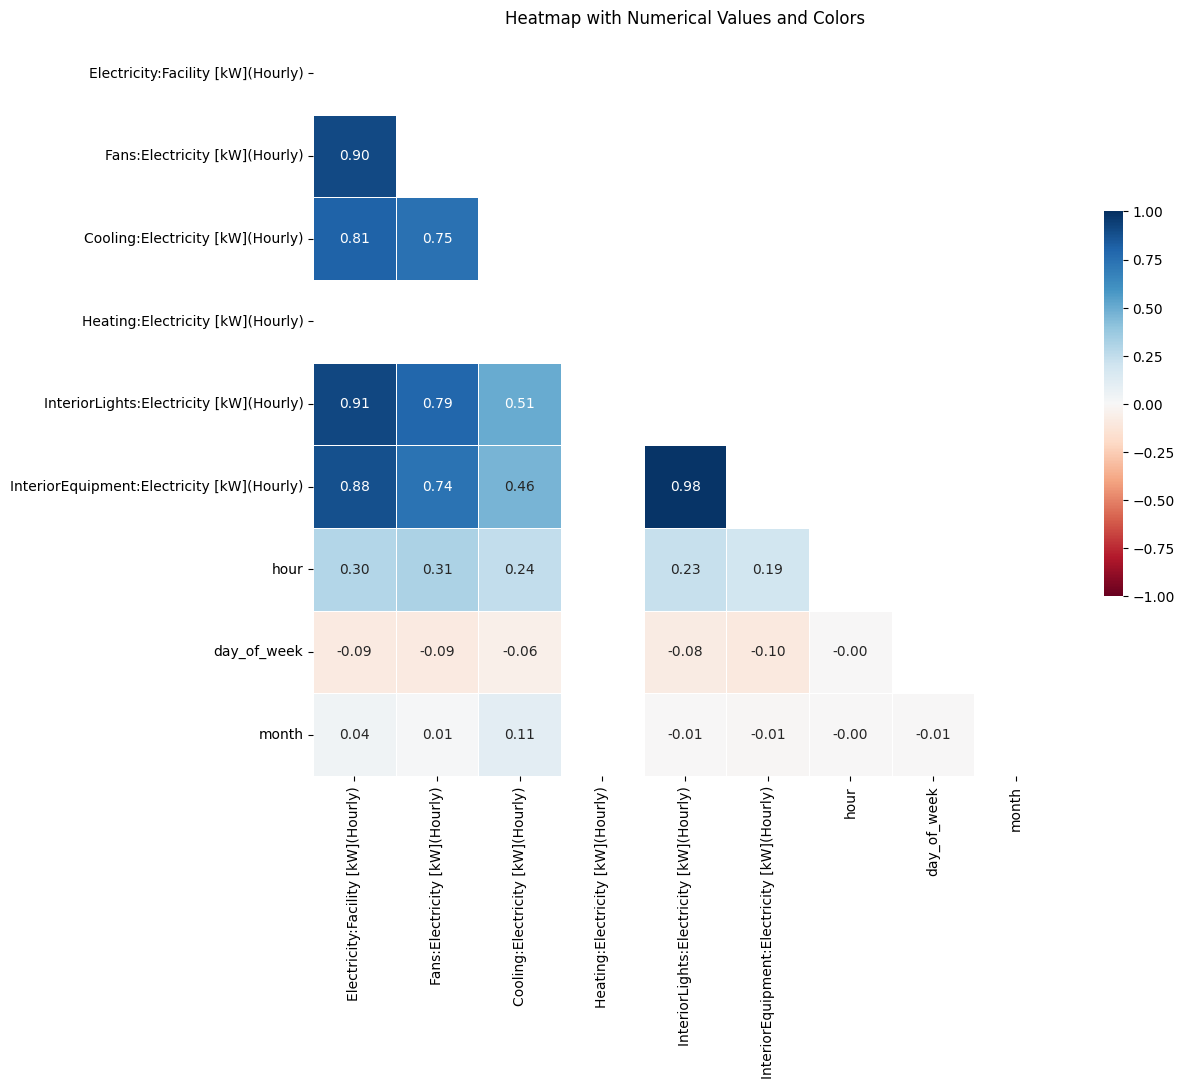

In [20]:
matriz_correlacion(average_cluster_1, target)

La correlación mide la relación entre dos variables. Puede ir de -1 a 1.

* 1 significa una relación positiva perfecta.
* -1 significa una relación negativa perfecta.
* 0 significa que no hay relación.

In [21]:
# Calcular la correlación de cada característica con la variable objetivo
correlation_matrix = average_cluster_1.corr()
target_correlation = correlation_matrix['Electricity:Facility [kW](Hourly)'].sort_values(ascending=False)

# Mostrar la correlación de cada característica con la variable objetivo
target_correlation


Electricity:Facility [kW](Hourly)             1.000000
InteriorLights:Electricity [kW](Hourly)       0.907174
Fans:Electricity [kW](Hourly)                 0.901297
InteriorEquipment:Electricity [kW](Hourly)    0.880300
Cooling:Electricity [kW](Hourly)              0.810210
hour                                          0.296415
month                                         0.044816
day_of_week                                  -0.088208
Heating:Electricity [kW](Hourly)                   NaN
Name: Electricity:Facility [kW](Hourly), dtype: float64

Queremos saber qué variables están más relacionadas con la variable que queremos predecir (Electricity:Facility [kW](Hourly)).

Las variables con alta correlación pueden ser más útiles para nuestro modelo.

**Regla utilizada:**

* Seleccionamos variables con una correlación absoluta mayor o igual a 0.3. 
* Esto significa que estas variables tienen una relación suficientemente fuerte con nuestra variable objetivo.

In [22]:
# Mantener características con correlación absoluta mayor o igual a 0.3
selected_features = target_correlation[abs(target_correlation) >= 0.3].index.drop('Electricity:Facility [kW](Hourly)')
features_corr = average_cluster_1[selected_features]

In [23]:
features_corr.columns

Index(['InteriorLights:Electricity [kW](Hourly)',
       'Fans:Electricity [kW](Hourly)',
       'InteriorEquipment:Electricity [kW](Hourly)',
       'Cooling:Electricity [kW](Hourly)'],
      dtype='object')

**Evaluación de la Multicolinealidad**

* La multicolinealidad ocurre cuando dos o más variables están altamente correlacionadas entre sí.

* Esto puede causar problemas en los modelos de regresión porque dificulta determinar el efecto individual de cada variable.
  
**¿Cómo evaluamos la multicolinealidad?**

* Usamos el Factor de Inflación de la Varianza (VIF). Un VIF alto (mayor a 10) indica multicolinealidad alta.

* Eliminamos las variables con VIF mayor a 10 para reducir la multicolinealidad y simplificar nuestro modelo.

In [24]:
# Paso 3: Evaluación de la Multicolinealidad
vif_before_corr = calculate_vif(features_corr)
vif_before_corr

,feature,VIF
0,InteriorLights:Electricity [kW](Hourly),8.927542
1,Fans:Electricity [kW](Hourly),10.980247
2,InteriorEquipment:Electricity [kW](Hourly),7.947184
3,Cooling:Electricity [kW](Hourly),4.184502


In [25]:
# Eliminar características con VIF alto (umbral de 10)
features_selected_corr, final_vif = remove_high_vif_features(features_corr)

In [26]:
final_vif

,feature,VIF
0,InteriorLights:Electricity [kW](Hourly),7.248154
1,InteriorEquipment:Electricity [kW](Hourly),7.405527
2,Cooling:Electricity [kW](Hourly),2.300133


In [27]:
features_selected_corr

,InteriorLights:Electricity [kW](Hourly),InteriorEquipment:Electricity [kW](Hourly),Cooling:Electricity [kW](Hourly)
Date/Time,,,
2004-01-01 01:00:00,24.920364,149.522181,31.908524
2004-01-01 02:00:00,24.920364,149.522181,26.785034
2004-01-01 03:00:00,24.920364,149.522181,32.976220
2004-01-01 04:00:00,24.920364,149.522181,26.787125
2004-01-01 05:00:00,24.920364,149.522181,33.244300
...,...,...,...
2004-12-31 19:00:00,24.920364,149.522181,1.254863
2004-12-31 20:00:00,24.920364,149.522181,0.926706
2004-12-31 21:00:00,24.920364,149.522181,0.686607


In [28]:
 taget_predict=average_cluster_1['Electricity:Facility [kW](Hourly)'].copy()

# Seleccion del modelo

In [29]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_corr, X_test_corr, y_train_corr, y_test_corr = train_test_split(features_selected_corr, taget_predict, test_size=0.2, random_state=42)

In [30]:
# Escalar las características
scaler_corr = StandardScaler()
X_train_scaled_corr = scaler_corr.fit_transform(X_train_corr)
X_test_scaled_corr = scaler_corr.transform(X_test_corr)

In [31]:
# Definición de modelos
models = {
    "Linear Regression": LinearRegression(),
    "Stepwise Linear Regression": Lasso(alpha=0.01),  # Utilizando Lasso como aproximación a la regresión paso a paso
    "Tree": DecisionTreeRegressor(),
    "SVM": SVR(kernel='rbf'),
    "Efficient Linear": LinearRegression(),  # Utilizando Linear Regression como proxy
    "Ensemble": VotingRegressor(estimators=[
        ('lr', LinearRegression()),
        ('lasso', Lasso(alpha=0.01)),
        ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
    ]),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
}

# Variables para almacenar resultados y modelos entrenados
results = {}
trained_models = {}

# Entrenar y evaluar cada modelo
for model_name, model in models.items():
    rmse_train, r2_train, rmse_test, r2_test = train_evaluate_model(model, X_train_scaled_corr, X_test_scaled_corr, y_train_corr, y_test_corr)
    results[model_name] = {
        'RMSE Train': rmse_train, 
        'R2 Train': r2_train,
        'RMSE Test': rmse_test, 
        'R2 Test': r2_test
    }
    # Guardar el modelo entrenado en el diccionario
    trained_models[model_name] = model

In [32]:
# Convertir a DataFrame y verificar overfitting
df_overfitting_results= pd.DataFrame(results)
df_overfitting_results.head()

,Linear Regression,Stepwise Linear Regression,Tree,SVM,Efficient Linear,Ensemble,Random Forest
RMSE Train,43.508639,43.508749,10.882499,43.327933,43.508639,31.898986,15.472027
R2 Train,0.990467,0.990467,0.999404,0.990546,0.990467,0.994876,0.998794
RMSE Test,43.578893,43.578585,35.730517,42.865221,43.578893,35.562745,31.161010
R2 Test,0.990569,0.990569,0.993660,0.990876,0.990569,0.993720,0.995178


# Mejorar hiperparametros

In [34]:
# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           cv=3,  # Validación cruzada de 3 pliegues
                           n_jobs=-1,  # Usar todos los núcleos disponibles
                           scoring='neg_root_mean_squared_error',  # Usar RMSE
                           verbose=2)

# Realizar la búsqueda en cuadrícula
grid_search.fit(X_train_scaled_corr, y_train_corr)

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_

Fitting 3 folds for each of 216 candidates, totalling 648 fits


In [35]:
print("Mejores hiperparámetros:", best_params)

Mejores hiperparámetros: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}


In [36]:
# Entrenar el modelo con los mejores hiperparámetros
optimized_rf_model = RandomForestRegressor(**best_params, random_state=42)
optimized_rf_model.fit(X_train_scaled_corr, y_train_corr)

# Evaluar el modelo optimizado
rmse_train_opt = np.sqrt(mean_squared_error(y_train_corr, optimized_rf_model.predict(X_train_scaled_corr)))
r2_train_opt = r2_score(y_train_corr, optimized_rf_model.predict(X_train_scaled_corr))

rmse_test_opt = np.sqrt(mean_squared_error(y_test_corr, optimized_rf_model.predict(X_test_scaled_corr)))
r2_test_opt = r2_score(y_test_corr, optimized_rf_model.predict(X_test_scaled_corr))

# Resultados
optimized_rf_results = {
    "Optimized Random Forest": {
        'RMSE Train': rmse_train_opt,
        'R2 Train': r2_train_opt,
        'RMSE Test': rmse_test_opt,
        'R2 Test': r2_test_opt
    }
}

In [37]:
# Mostrar los resultados
print("Resultados del modelo Random Forest optimizado:")
optimized_rf_results_df=pd.DataFrame(optimized_rf_results)
optimized_rf_results_df

Resultados del modelo Random Forest optimizado:


,Optimized Random Forest
R2 Test,0.996077
R2 Train,0.997022
RMSE Test,28.105243
RMSE Train,24.318901


In [38]:
dump(optimized_rf_model, '../models/modelo_average_cluster_1.joblib')
dump(scaler_corr, '../models/scaler_average_cluster_1.joblib')

['../models/scaler_average_cluster_1.joblib']